In [ ]:
import networkx as nx
import numpy as np

def generate_multi_way_graph(selected_clusters, non_selected_clusters, p, q):
    """
    Generates a multi-way graph based on the selected and non-selected clusters.

    Parameters:
    selected_clusters (list): List of sizes of selected clusters.
    non_selected_clusters (list): List of sizes of non-selected clusters.
    p (float): Probability for intra-cluster edge creation.
    q (float): Probability for inter-cluster edge creation.

    Returns:
    A (np.ndarray): Adjacency matrix representing the multi-way graph.
    L (np.ndarray): Laplacian matrix of the graph.
    """

    cluster_sizes = selected_clusters + non_selected_clusters
    total_nodes = sum(cluster_sizes)
    cluster_labels = []

    # Assign each node a cluster label
    label = 0
    for size in cluster_sizes:
        cluster_labels.extend([label] * size)
        label += 1

    cluster_labels = np.array(cluster_labels)
    A = np.zeros((total_nodes, total_nodes))

    for i in range(total_nodes):
        for j in range(i + 1, total_nodes):
            same_cluster = cluster_labels[i] == cluster_labels[j]
            prob = p if same_cluster else q
            if np.random.rand() < prob:
                A[i, j] = A[j, i] = 1

    G = nx.from_numpy_array(A)
    L = nx.laplacian_matrix(G).toarray()

    return A, L

In [15]:
A, L = generate_multi_way_graph([10, 10], [20, 20], 0.9, 0.3)

In [16]:
L

array([[19., -1., -1., ...,  0.,  0.,  0.],
       [-1., 20., -1., ...,  0., -1.,  0.],
       [-1., -1., 20., ..., -1.,  0.,  0.],
       ...,
       [ 0.,  0., -1., ..., 36., -1., -1.],
       [ 0., -1.,  0., ..., -1., 28., -1.],
       [ 0.,  0.,  0., ..., -1., -1., 29.]])

In [17]:
A

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

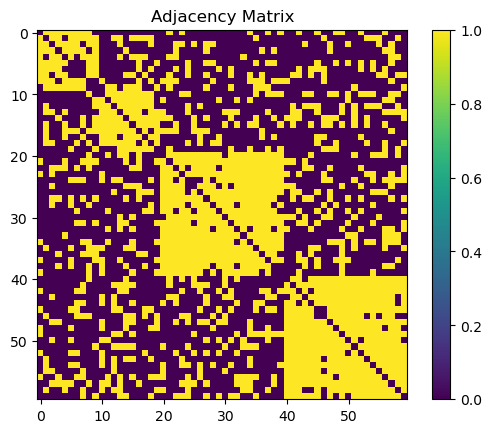

In [18]:
# plot the matrix
import matplotlib.pyplot as plt
plt.imshow(A, cmap='viridis', interpolation='nearest')
plt.title("Adjacency Matrix")
plt.colorbar()
plt.show()

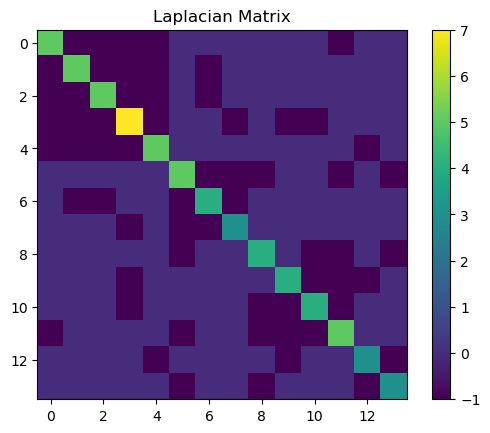

In [14]:
plt.imshow(L, cmap='viridis', interpolation='nearest')
plt.title("Laplacian Matrix")
plt.colorbar()
plt.show()

In [34]:
import matlab.engine
import os
from utils.communication import save_data, read_result
def call_matlab(datafile, resultfile, rho, mu, k=None):
    eng = matlab.engine.start_matlab()
    try:
        eng.cd(os.path.abspath('./src/PQN/'))
        eng.addpath(os.path.abspath('./src/PQN/'))
        eng.addpath(eng.genpath(os.path.abspath('./src/PQN/')))
        eng.addpath(eng.genpath(os.path.abspath('./src/PQN/minConF/')))
        eng.gfl_multi(datafile, resultfile, rho, mu, float(k), nargout=0)
    finally:
        eng.quit()

def gfl_multi(X, y, L, i, k=None, rho=None, mu=0.01, datafile=None, resultfile=None):
    datafile_name = os.path.join(datafile, f'data_{i}.mat')
    resultfile_name = os.path.join(resultfile, f'result_{i}.mat')
    save_data(X=X, y=y, L=L, filename=datafile_name)
    call_matlab(datafile_name, resultfile_name, rho, mu, k)
    u, _ = read_result(resultfile_name)
    return u.flatten()

def gfl_ratio():
    pass

In [40]:
# === Standard Library ===
import os, time, sys
import numpy as np
from collections import defaultdict

from solvers.adaptive_grace import adaptive_grace
from solvers.lasso import lasso
from solvers.gfl_pqn import gfl_pqn
from solvers.gfl_proximal import gfl_proximal
from utils.communication import A_to_edges

# need to import the sparse_module.so in ./src/
# sys.path.insert(0, os.path.join(os.path.dirname(__file__), "src"))
# from solvers.signal_family import sparse_learning_solver

class Solver:    
    def __init__(self, models, c=1):   
        
        self.res = defaultdict(list)
        self.models = models
        self.n = None
        self.d = None
        self.k = None
        self.c = c
        # self.datafile = os.path.join(os.path.abspath(datafile), f'real_data')
        # self.resultfile = os.path.join(os.path.abspath(resultfile), f'real_data') # matlab does not like relative path
        # self.datafile_pqn = os.path.join(os.path.abspath('./src/PQN/data/'), f'real_data')
        # self.resultfile_pqn = os.path.join(os.path.abspath('./src/PQN/result/'), f'real_data')
        self.datafile = os.path.abspath('./data/data_gfl/')
        self.resultfile = os.path.abspath('./data/result_gfl/') 
        self.datafile_pqn = os.path.abspath('./data/data_PQN/')
        self.resultfile_pqn = os.path.abspath('./data/result_PQN/')
        self._init(self.datafile, self.resultfile)
        self._init(self.datafile_pqn, self.resultfile_pqn)


    def _init(self, datafile, resultfile):
        if not os.path.exists(datafile):
            os.makedirs(datafile)
        if not os.path.exists(resultfile):
            os.makedirs(resultfile)

    def _solver_lasso(self, X, y, alpha=0.1):
        return lasso(X, y, alpha=alpha)

    def _solver_adaptive_grace(self, X, y, W, lambda1=1.0, lambda2=1.0, max_iter=1000, tol=1e-4):
        return adaptive_grace(X, y, W, lambda1=lambda1, lambda2=lambda2, max_iter=max_iter, tol=tol)
    
    def _solver_gfl_proximal(self, X, y, A, i, rho1=0.5, rho2=0.5):
        return gfl_proximal(X, y, A, i, datafile=self.datafile, resultfile=self.resultfile, rho1=rho1, rho2=rho2)
    
    def _solver_gfl_pqn(self, X, y, L, i, k, rho=None, mu=0.01):
        if rho is None:
            return gfl_pqn(X, y, L, i, rho=np.sqrt(self.n), mu=mu, k=k, datafile=self.datafile_pqn, resultfile=self.resultfile_pqn)
        else:
            return gfl_pqn(X, y, L, i, rho=rho, mu=mu, k=k, datafile=self.datafile_pqn, resultfile=self.resultfile_pqn)
        
    def _solver_gfl_multi(self, X, y, L, i, k, rho=None, mu=0.01):
        return gfl_multi(X, y, L, i, rho=np.sqrt(self.n), mu=mu, k=k, datafile=self.datafile_pqn, resultfile=self.resultfile_pqn)
    
    def _solver_gfl_ratio(self, X, y, L, A, i):
        return gfl_ratio(X, y, L, A, i, datafile=self.datafile, resultfile=self.resultfile)

    def _solver_signal_family(self, X, y, i, s, c=1, g=1, max_epochs=50, tol_algo=1e-20, step=1, edges=None, costs=None,):
        # s is the number of sparsity level, w is x_star in their codecase, gamma=0.5 control the noise
        return sparse_learning_solver((i, X, y, edges, costs, s, g, max_epochs, tol_algo, step, c))
   

    def _single_runtime(self, model, X, y, k, c=1, L=None, A=None, i=None, rho=15.0, mu=0.1, rho1=0.5, rho2=0.5):
        start_time = time.time()
        self.solver(model, X, y, k, c=c, L=L, A=A, i=i, rho=rho, mu=mu, rho1=rho1, rho2=rho2)
        end_time = time.time()
        return end_time - start_time


    def solver(self, model, X, y, k, c=1, L=None, A=None, i=None, rho=15.0, mu=0.1, rho1=0.5, rho2=0.5):
        if model == "lasso":
            return self._solver_lasso(X, y)
        elif model == "adaptive_grace":
            return self._solver_adaptive_grace(X, y, L)
        elif model == "gfl_proximal":
            return self._solver_gfl_proximal(X, y, A, i, rho1=rho1, rho2=rho2)
        elif model == "gfl_pqn":
            return self._solver_gfl_pqn(X, y, L, i, k, rho=rho, mu=mu)
        elif model == "signal_family":
            edges, costs = A_to_edges(A)
            return self._solver_signal_family(X, y, i=i, s=k, c=c, edges=edges, costs=costs)
        elif model == "gfl_multi":
            return self._solver_gfl_multi(X, y, L, i, k, rho=rho, mu=mu)
        elif model == "gfl_ratio":
            return self._solver_gfl_ratio(X, y, L, A, i)
        else:   
            raise ValueError(f"Unknown model: {model}. Supported models are: lasso, adaptive_grace, gfl_proximal, gfl_pqn, signal_family.")
        

    def fit(self, X, y, L, A, k, i=None, verbose=False):
        self.n, self.d = X.shape
        self.k = k
        for model in self.models:
            if model == "signal_family":
                u = self.solver(model, X, y, k, c=self.c, L=L, A=A, i=i)
                # unpack the result
                _, results = u
                for method, (x_hat, *_) in results.items():
                    if verbose:
                        print(f"Running {method}")
                    self.res[method] = x_hat
            else:
                if verbose:
                    print(f"Running {model}")
                u = self.solver(model, X, y, k, L=L, A=A, i=i)
                self.res[model] = u

        return self.res



In [44]:
import numpy as np
# from utils.graph import generate_multi_way_graph
class RandomEnsembleMultiClass:
    def __init__(self, n, d, k, gamma, p, q, h_total, h_selected, h_non_selected):
        self.n, self.d, self.k = n, d, k
        self.gamma = gamma
        self.p, self.q = p, q
        self.h_total, self.h_selected, self.h_non_selected = h_total, h_selected, h_non_selected
        assert h_total == h_selected + h_non_selected, "Total clusters must equal the sum of selected and non-selected clusters."  

    def _generate_clusters(self):
        # divide the total number of d into h_total clusters as even as possible,
        # also make sure that the first h_selected clusters have k elements in total
        # we always assume that the first h_selected clusters are the selected ones
        selected_clusters = []

        # generate the first h_selected clusters
        for i in range(self.h_selected):
            cluster_size = self.k // self.h_selected
            if i < self.k % self.h_selected:
                cluster_size += 1   # 17 + 17 + 16 = 50
            selected_clusters.append(cluster_size)
        
        non_selected_clusters = []
        # generate the remaining h_non_selected clusters
        remaining_d = self.d - self.k
        for i in range(self.h_non_selected):
            cluster_size = remaining_d // self.h_non_selected
            if i < remaining_d % self.h_non_selected:
                cluster_size += 1
            non_selected_clusters.append(cluster_size)

        return selected_clusters, non_selected_clusters
    
    def _generate_graph(self, selected_clusters, non_selected_clusters):        
        return generate_multi_way_graph(selected_clusters, non_selected_clusters, self.p, self.q)
        

    def _generate_w(self, selected_clusters, non_selected_clusters):
        w = np.zeros(self.d)
        start_index = 0
        for size in selected_clusters:
            clsuter_weight = np.random.normal(0, 1)
            w[start_index:start_index + size] = clsuter_weight
            start_index += size
        
        for size in non_selected_clusters:
            w[start_index:start_index + size] = 0
            start_index += size
        return w

    def _generate_X(self):
        X = np.random.normal(0, 1, (self.n, self.d))
        return X

    def _generate_y(self, X, w):
        signal = X @ w
        noise = np.random.normal(0, self.gamma, size=signal.shape)                 
        y = signal + noise
        return y
    
    def _generate_data(self):
        selected_clusters, non_selected_clusters = self._generate_clusters()
        L, A = self._generate_graph(selected_clusters, non_selected_clusters)
        w = self._generate_w(selected_clusters, non_selected_clusters)
        X = self._generate_X()
        y = self._generate_y(X, w)
        return L, A, X, y, w
    
    def _recovery_accuracy(self, u):
        # evaluate the support recovery accuracy
        selected_features_true = np.arange(self.k)
        selected_features_pred = np.argsort(np.abs(u))[-self.k:] 
        correct_pred = np.intersect1d(selected_features_true, selected_features_pred)
        accuracy = len(correct_pred) / self.k
        return accuracy
    
    def _report(self, model_accuracy):
        for model, accuracy in model_accuracy.items():
            avg_accuracy = np.mean(accuracy)
            std_accuracy = np.std(accuracy)
            print(f"Model: {model}, Avg. Accuracy: {avg_accuracy}, Std. Accuracy: {std_accuracy}")

    
    def run(self, num_replications=1, models=["gfl_multi"]):
        model_accuracy = defaultdict(list)
        solver = Solver(models=models)
        for i in range(num_replications):
            L, A, X, y, w = self._generate_data()
            results = solver.fit(X, y, L, A, k=self.k, i=i, verbose=1)
            for model, u in results.items():
                accuracy = self._recovery_accuracy(u)
                model_accuracy[model].append(accuracy)
        
        self._report(model_accuracy)
        return model_accuracy
    


In [51]:
test = RandomEnsembleMultiClass(n=100, d=100, k=20, gamma=0.1, p=0.9, q=0.1, h_total=10, h_selected=2, h_non_selected=8)
# just get the last generated data
*_, w = test._generate_data()
print(w)
print(test._generate_clusters())
# print(test._generate_data())

[1.77666685 1.77666685 1.77666685 1.77666685 1.77666685 1.77666685
 1.77666685 1.77666685 1.77666685 1.77666685 0.56402698 0.56402698
 0.56402698 0.56402698 0.56402698 0.56402698 0.56402698 0.56402698
 0.56402698 0.56402698 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

In [52]:
test.run()

Running gfl_multi


Error using gfl_multi>ProjectToDoublyStochasticGurobi (line 105)
Projection failed.

Error in gfl_multi>@(m)ProjectToDoublyStochasticGurobi(m,d,k) (line 26)
    funProj = @(m) ProjectToDoublyStochasticGurobi(m, d, k);
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Error in minConF_PQN (line 79)
x = funProj(x);
    ^^^^^^^^^^
Error in gfl_multi (line 35)
    [m_opt, fval, evals] = minConF_PQN(funObj, m_init, funProj, options);
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



MatlabExecutionError: 
  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/multi-cluster-sparse-learning/src/PQN/gfl_multi.m, line 105, in ProjectToDoublyStochasticGurobi

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/multi-cluster-sparse-learning/src/PQN/gfl_multi.m, line 26, in @(m)ProjectToDoublyStochasticGurobi(m,d,k)

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/multi-cluster-sparse-learning/src/PQN/minConF/minConF_PQN.m, line 79, in minConF_PQN

  File /Users/aolongli/Desktop/Research-GFL/Experiement/code/multi-cluster-sparse-learning/src/PQN/gfl_multi.m, line 35, in gfl_multi
Projection failed.
